# Import Libraries

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc
from scipy.stats import norm, f, t
from scipy.ndimage import rotate
from PIL import Image

# Define Parameters

In [2]:
# Define parameters
subjects = 57

# Define Data

In [97]:
anatomical = nib.load('Unthresholded/neurosynth/anatomical.nii.gz').get_fdata()
spmT = nib.load('Unthresholded/neurosynth/TMap_1.nii.gz').get_fdata()
mask = nib.load('Unthresholded/neurosynth/mask.nii.gz').get_fdata()
spmT_masked=mask*spmT

# Original TMap Image

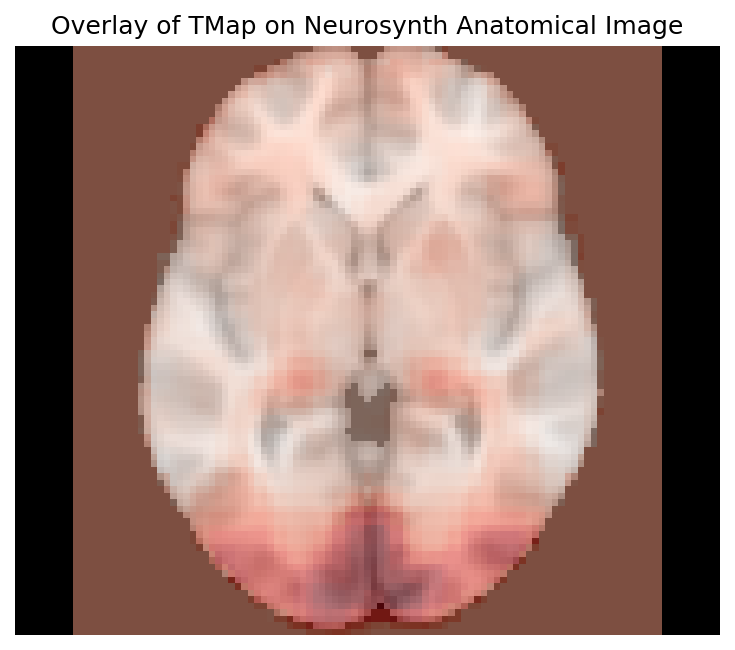

In [44]:
# Define the slice index
slice_idx = 36

# Extract the anatomical and contrast slices
anatomical_slice = anatomical[:, :, slice_idx]
contrast_slice = spmT_masked[:, :, slice_idx]

# Rotate for visualization
rotated_anatomical = np.flip(rotate(anatomical_slice, 90, reshape=False), axis=1)
rotated_contrast = np.flip(rotate(contrast_slice, 90, reshape=False), axis=1)

# Plot
plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(rotated_anatomical, cmap='gray')
plt.imshow(np.ma.masked_where(rotated_contrast == 0, rotated_contrast), cmap='Reds', alpha=0.5)
plt.title(f"Overlay of TMap on Neurosynth Anatomical Image", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()


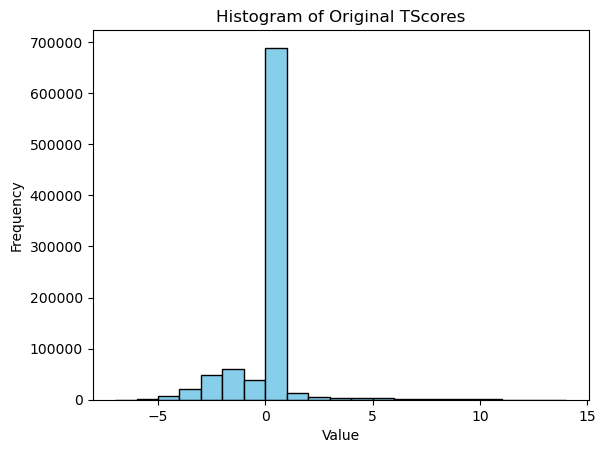

In [98]:
# Plot histogram of original TMap values

# Flatten image data
spmT_img = spmT.flatten()

#Plot
# Create the histogram
bin_edges = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.hist(spmT_img, bins=bin_edges, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Original TScores')

# Show the plot
plt.show()


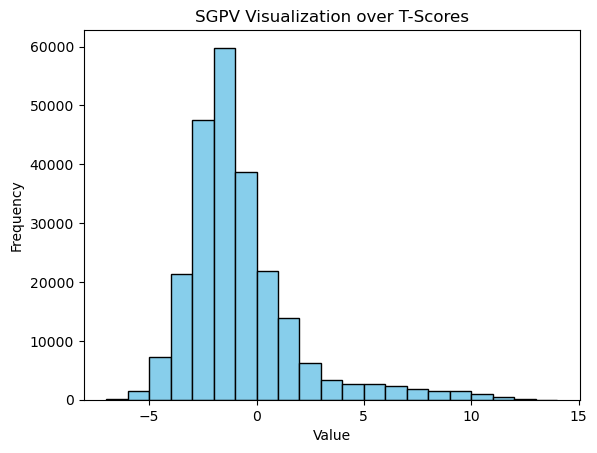

In [101]:
#Plot T-scores not 0
spmT_img_0 = [x for x in spmT_img if x != 0]
# Create the histogram
bin_edges = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.hist(spmT_img_0, bins=bin_edges, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('SGPV Visualization over T-Scores')

# Show the plot
plt.show()

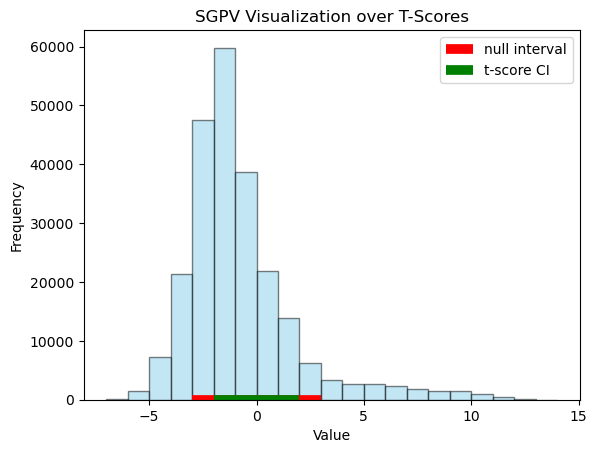

In [107]:
import matplotlib.pyplot as plt

# Plot T-scores not 0
spmT_img_0 = [x for x in spmT_img if x != 0]

# Create the histogram
bin_edges = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.hist(spmT_img_0, bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.5)

# Add horizontal lines spanning -3 to 3 and -2 to 2 at y=0
plt.hlines(y=0, xmin=-3, xmax=3, colors='red', linewidth=7, label='null interval')
plt.hlines(y=0.5, xmin=-2, xmax=2, colors='green', linewidth=7, label='t-score CI')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('SGPV Visualization over T-Scores')

# Add legend
plt.legend()

# Show the plot
plt.show()


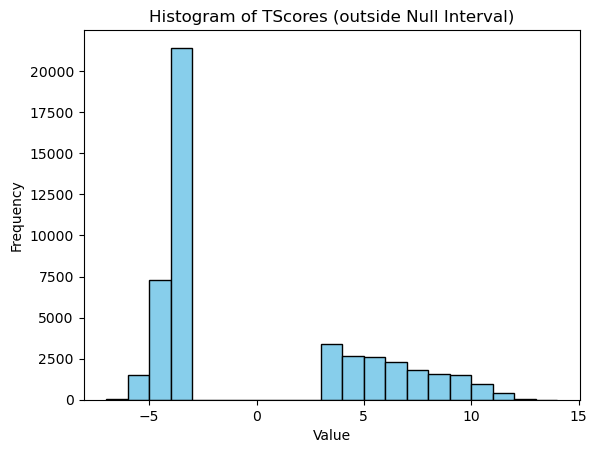

In [ ]:
#Plot Significant TScores only (outside null interval)
spmT_img_outside_null = [x for x in spmT_img if (x < -3) | (x > 3)]
# Create the histogram
bin_edges = [-7, -6, -5, -4, -3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.hist(spmT_img_outside_null, bins=bin_edges, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of TScores (outside Null Interval)')

# Show the plot
plt.show()

# Power

In [41]:
# Function for power calculations
def power_calcs2(df1, df2, f2, alpha):

    Fcrit = f.ppf(1 - alpha, df1, df2) # returns the inverse cumulative distribution function of the F distribution with degrees of freedom df1 and df2, evaluated at the probability value of 1 - alpha

    lambda_ = (df1 + df2 + 1) * f2
    kappa = (df1 + lambda_) / df1
    df2_lambda = ((df1 + lambda_) ** 2) / (df1 + 2 * lambda_)

    F_prime = Fcrit / kappa
    x = (df2_lambda * F_prime) / (df2 + df2_lambda * F_prime)
    beta = betainc(df2_lambda / 2, df2 / 2, x)

    power = 1 - beta

    return power

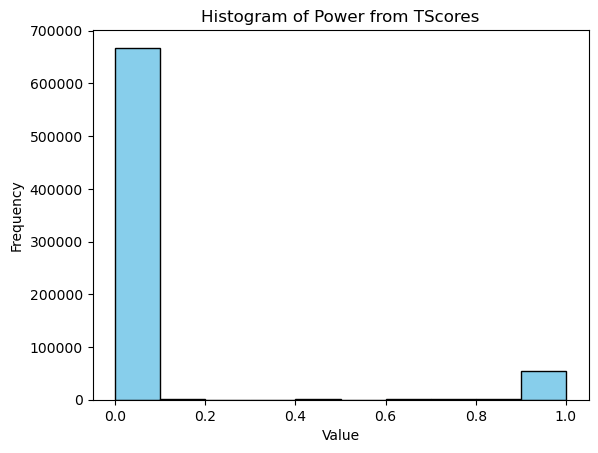

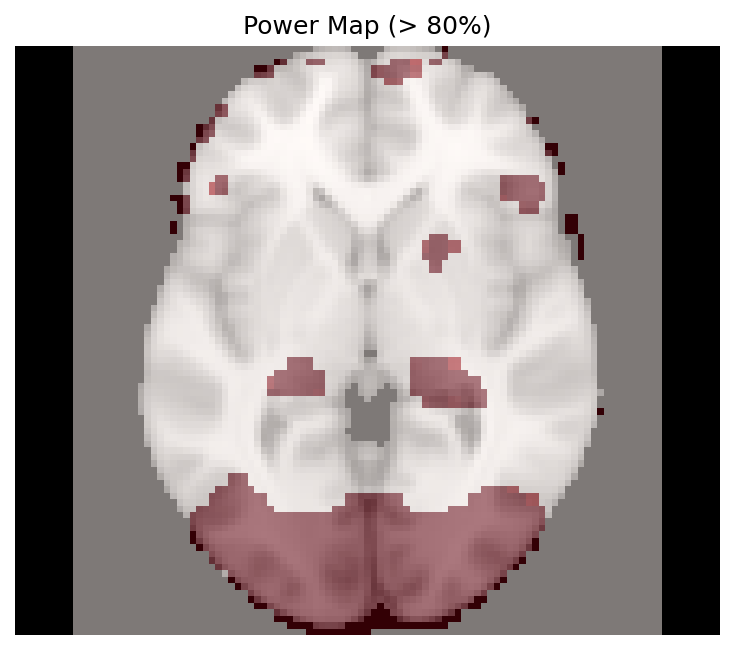

In [49]:
# Get image dimensions correctly
XDIM, YDIM, ZDIM = spmT_masked.shape
PowerImage = np.zeros((XDIM, YDIM, ZDIM))
PowerImage_2 = np.zeros((XDIM, YDIM, ZDIM))

for i in range(XDIM):
    for j in range(YDIM):
        for k in range(ZDIM):
            if spmT_masked[i, j, k] != 0:
                stat_power = power_calcs2(
                                    df1 = 1, 
                                    df2 = subjects, 
                                    f2 = spmT_masked[i, j, k],
                                    alpha = 0.05
                                    )
                PowerImage_2[i, j, k] = stat_power
                if stat_power >= 0.8:
                    PowerImage[i, j, k] = stat_power


# Create the histogram
plt.hist(PowerImage_2.flatten(), bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Power from TScores')

# Show the plot
plt.show()


# Define the slice index
slice_idx = 36

# Extract the anatomical and contrast slices
anatomical_slice = anatomical[:, :, slice_idx]
contrast_slice = PowerImage[:, :, slice_idx]

# Rotate for visualization
rotated_anatomical = np.flip(rotate(anatomical_slice, 90, reshape=False), axis=1)
rotated_contrast = np.flip(rotate(contrast_slice, 90, reshape=False), axis=1)

# Plot
plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(rotated_anatomical, cmap='gray')
plt.imshow(np.ma.masked_where(rotated_contrast == 0, rotated_contrast), cmap='Reds', alpha=0.5)
plt.title(f"Power Map (> 80%)", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

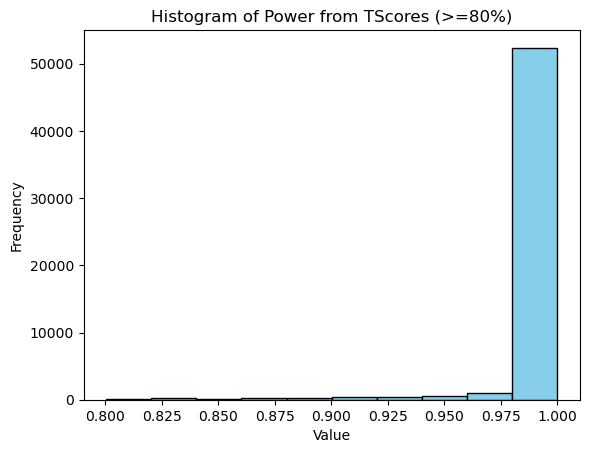

In [ ]:
# Plot Voxels with Significant Power only (>= 80%)
PowerImage_significant = [x for x in PowerImage.flatten() if x >= 0.8]
# Create the histogram
plt.hist(PowerImage_significant, bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Power from TScores (>=80%)')

# Show the plot
plt.show()

# Statistical P-Val

In [26]:
# Function to convert t-statistics to p-values
def t_to_p_array(t_scores, degrees_of_freedom, tails=1):
    p = t.cdf(t_scores, df=degrees_of_freedom)
    if tails == 2:
        return 2 * (1 - np.abs(p - 0.5) * 2)
    elif tails == 1:
        # Conditional logic vectorized for 1-tailed test
        return np.where(t_scores >= 0, 1 - p, p)

In [27]:
# Statistical P-Val
def statp(anatomical, spmT_masked, subjects, alpha, cutoff, df=1):
    # Convert T-scores to p-values
    contrast_img_p = t_to_p_array(spmT_masked, subjects, tails=df)

    # Define the slice index
    slice_idx = 36

    # Extract the anatomical and p-value slices
    anatomical_slice = anatomical[:, :, slice_idx]
    contrast_slice = contrast_img_p[:, :, slice_idx]

    # Rotate for visualization
    rotated_anatomical = np.flip(rotate(anatomical_slice, 90, reshape=False), axis=1)
    rotated_contrast = np.flip(rotate(contrast_slice, 90, reshape=False), axis=1)

    # Mask to focus on significant p-values (e.g., p < 0.05)
    mask = rotated_contrast < alpha
    masked_contrast = np.ma.masked_where(~mask, 1 - rotated_contrast)  # Invert values: low p = high intensity

    # Plot
    plt.figure(figsize=(5, 5), dpi=150)
    plt.imshow(rotated_anatomical, cmap='gray')
    im = plt.imshow(masked_contrast, cmap='Reds', alpha=0.5, vmin=1-cutoff, vmax=1)

    # Add colorbar legend
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('1 - p-value (significance intensity)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    plt.title(f"P-value Map (p < {alpha})", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('statp.png')
    plt.close()

    return contrast_img_p


# Second Gen P-val

In [28]:
# Function to compute z-score from alpha
def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = norm.ppf(alpha)
    elif tail == 'right':
         z = norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z

In [ ]:
# Function for second generation p-value calculations
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, n, alpha, df):
    """
    Calculate second-generation p-value for neuroimaging data

    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (t scores)
        null_hypothesis (float): Point null hypothesis value (0)
        effect_interval (float): Interval of practically equivalent effects (User provides this - we need to test this value)
        f2 (float): Cohen's f-squared effect size
        n (int): Sample size
        alpha (float): Significance level
        df (int): Degrees of freedom
        verbose (bool): If True, print intermediate calculations. If False, suppress output.

    Returns:
        tuple: (delta_p, interpretation)
    """
    
    if df == 2:
        std = z_score_from_alpha(alpha, tail='two-sided')
    elif df == 1:
        std = z_score_from_alpha(alpha, tail='right')
    else:
        std = 1  # fallback to prevent crash
    
    std_error = std / np.sqrt(n - df)

    ci_lower = observed_effect - std_error
    ci_upper = observed_effect + std_error
    interval_lower = null_hypothesis - effect_interval
    interval_upper = null_hypothesis + effect_interval
    
    if ci_upper <= interval_upper and ci_lower >= interval_lower:
        delta_p = 1.0
        #interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper:
        delta_p = 0.0
        #interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2 * (interval_upper - interval_lower)):
        delta_p = 0.5
        #interpretation = 'Data is strictly inconclusive'
    else:
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        #interpretation = 'Partial evidence, some consistency with null'

    return delta_p

In [85]:
# Second Generation P-Val
def secgenp(anatomical, spmT_masked, subjects, alpha, df, cutoff, null_interval):
    XDIM, YDIM, ZDIM = spmT_masked.shape
    PVal2Image = np.zeros((XDIM, YDIM, ZDIM))

    for i in range(XDIM):
        for j in range(YDIM):
            for k in range(ZDIM):
                if spmT_masked[i, j, k] != 0:
                    contrast_img_2p = calculate_second_gen_p_value(
                        observed_effect=spmT_masked[i, j, k],
                        null_hypothesis=0,
                        effect_interval=null_interval,
                        n=subjects,
                        alpha=alpha,
                        df=df
                    )
                    PVal2Image[i, j, k] = contrast_img_2p

    # Define the slice index
    slice_idx = 36

    # Extract the anatomical and p-value slices
    anatomical_slice = anatomical[:, :, slice_idx]
    contrast_slice = PVal2Image[:, :, slice_idx]

    # Rotate for visualization
    rotated_anatomical = np.flip(rotate(anatomical_slice, 90, reshape=False), axis=1)
    rotated_contrast = np.flip(rotate(contrast_slice, 90, reshape=False), axis=1)

    # Mask to focus on significant p-values (e.g., p < cutoff)
    mask = rotated_contrast < cutoff
    masked_contrast = np.ma.masked_where(~mask, 1 - rotated_contrast)  # Invert for visual intensity

    # Plot
    plt.figure(figsize=(5, 5), dpi=150)
    plt.imshow(rotated_anatomical, cmap='gray')
    #plt.imshow(masked_contrast, cmap='Reds', alpha=0.5)
    im = plt.imshow(masked_contrast, cmap='Reds', alpha=0.5, vmin=1-cutoff, vmax=1)

    # Add colorbar legend
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('1 - Second Gen p-value (significance intensity)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    plt.title(f"Second Gen P-value Map (secgenp <= {cutoff})", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('secgenp.png')
    plt.close()


# Compare P-Vals

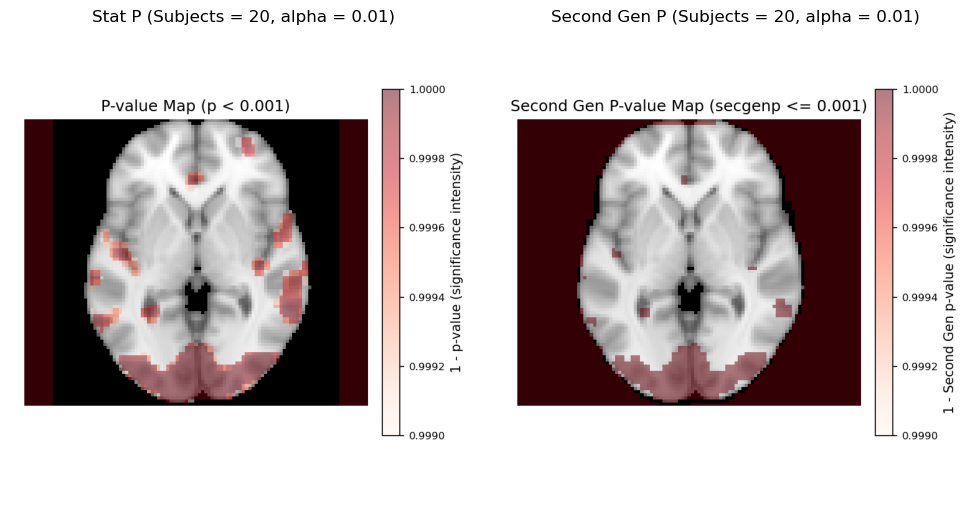

In [ ]:
# Plot P Val and Second Gen p-Val side-by side comparing subjects, alpha, and cutoff (Small Sample Size)

# Define parameters
subjects = 20 # study has N=57
alpha=0.001
df=1
cutoff= 0.001 # for second gen p-val

# Call and Load stat p image
contrast_img_p = statp(anatomical, spmT_masked, subjects, alpha, cutoff, df)
img = Image.open('statp.png')

# Call and Load Second Gen p image
secgenp(anatomical, spmT_masked, subjects, alpha, df, cutoff, null_interval=3.85)
img2 = Image.open('secgenp.png')

# Create a 1x2 subplot and display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title('Stat P (Subjects = 20, alpha = 0.001)')
axes[0].axis('off')  # Hide axes

axes[1].imshow(img2)
axes[1].set_title('Second Gen P (Subjects = 20, alpha = 0.001)')
axes[1].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

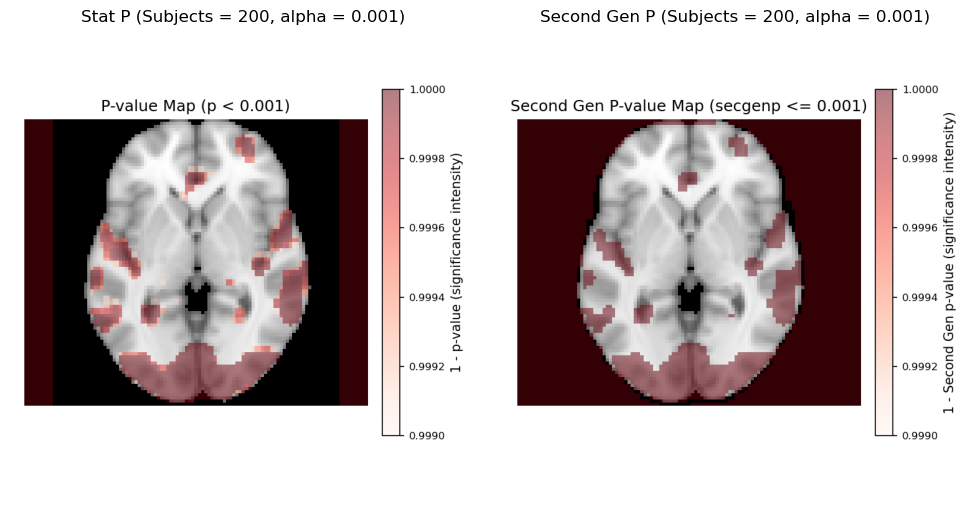

In [95]:
# Plot P Val and Second Gen p-Val side-by side comparing subjects, alpha, and cutoff (Large Sample Size)

# Define parameters
subjects = 200 # study has N=57
alpha=0.001
df=1
cutoff= 0.001 # for second gen p-val

# Call and Load stat p image
contrast_img_p = statp(anatomical, spmT_masked, subjects, alpha, cutoff, df)
img = Image.open('statp.png')

# Call and Load Second Gen p image
secgenp(anatomical, spmT_masked, subjects, alpha, df, cutoff, null_interval=3.291)
img2 = Image.open('secgenp.png')

# Create a 1x2 subplot and display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title('Stat P (Subjects = 200, alpha = 0.001)')
axes[0].axis('off')  # Hide axes

axes[1].imshow(img2)
axes[1].set_title('Second Gen P (Subjects = 200, alpha = 0.001)')
axes[1].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

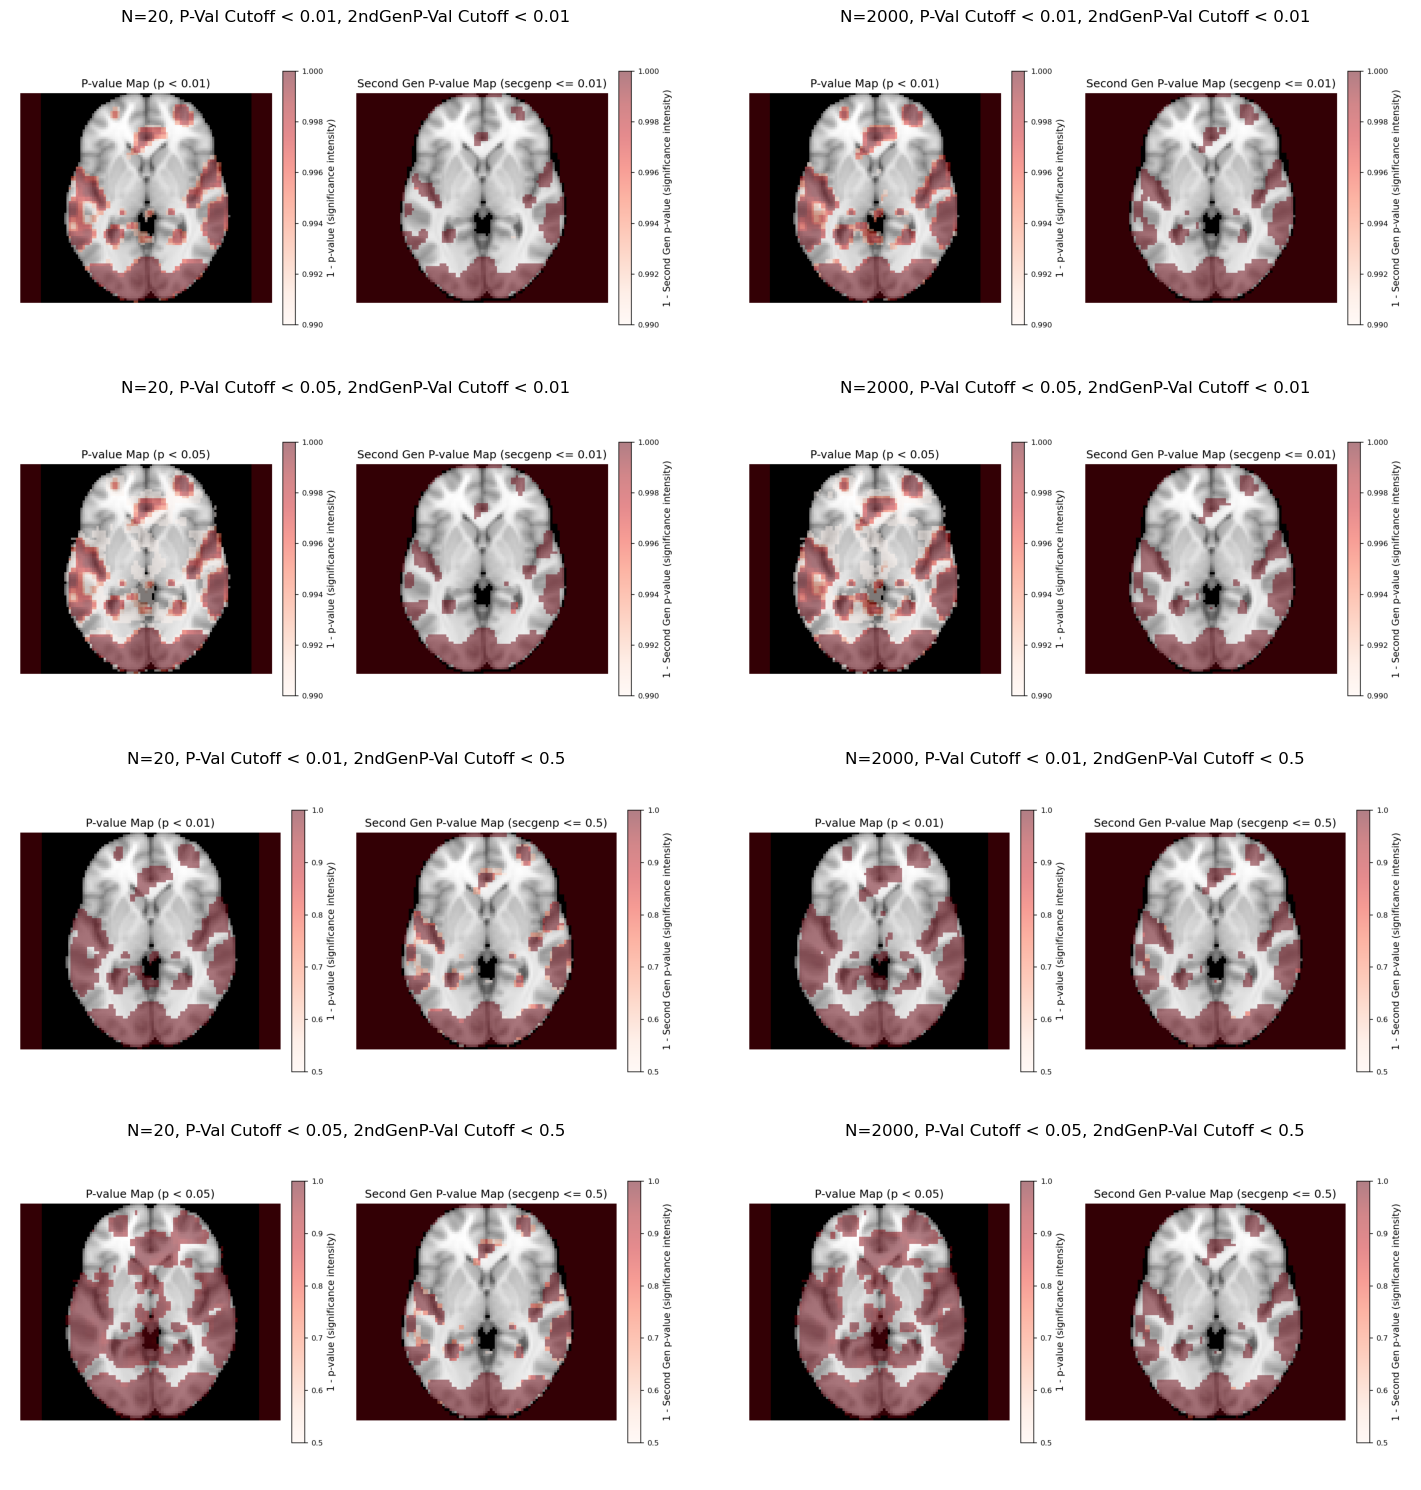

In [ ]:
# not configured to change null interval based on n and alpha
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product

# Define parameter options
subjects_list = [20, 200]
alpha_list = [0.001, 0.01]
cutoff_list = [0.01, 0.5]
df = 1

# Create all combinations
param_combinations = list(product(cutoff_list, alpha_list, subjects_list))

# Create a 3x3 grid of plots
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

for idx, (cutoff, alpha, subjects) in enumerate(param_combinations):
    row = idx // 2
    col = idx % 2

    # Call and load Stat P image
    statp(anatomical, spmT_masked, subjects, alpha, cutoff, df)
    img_statp = Image.open('statp.png')

    # Call and load Second Gen P image
    secgenp(anatomical, spmT_masked, subjects, alpha, df, cutoff)
    img_secgenp = Image.open('secgenp.png')

    # Combine images side-by-side
    combined_width = img_statp.width + img_secgenp.width
    combined_height = max(img_statp.height, img_secgenp.height)
    combined_img = Image.new('RGB', (combined_width, combined_height))
    combined_img.paste(img_statp, (0, 0))
    combined_img.paste(img_secgenp, (img_statp.width, 0))

    # Show in grid
    axes[row, col].imshow(combined_img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"N={subjects}, P-Val Cutoff < {alpha}, 2ndGenP-Val Cutoff < {cutoff}")

plt.tight_layout()
plt.show()


# SGPV with T-Stats Plot

In [ ]:
# sort each voxel by classical p-value rank (smallest to largest) - show on x-axis (rank by p-val transformed from t-stat)
# display 95% CIs for each p-value (transformed from t-stats) -> they don't have CIs though (use t-stat and se instead)
# show horizontal lines from -3 to 3 t-stat to show interval null hypothesis
# color code each CI with red if SGPV = 0 and blue if not
# show bonferroni cutoff vertical line - with FDR criterion of 0.05 or 5% and X number of voxels - cutoff would be at 0.05/number of comparisons (might be more than just number of voxels)

In [5]:
# Function for second generation p-value calculations
def calculate_second_gen_p_value_cis(observed_effect, null_hypothesis, effect_interval, n, alpha, df):
    
    if df == 2:
        std = z_score_from_alpha(alpha, tail='two-sided')
    elif df == 1:
        std = z_score_from_alpha(alpha, tail='right')
    else:
        std = 1  # fallback to prevent crash
    
    std_error = std / np.sqrt(n - df)

    ci_lower = observed_effect - std_error
    ci_upper = observed_effect + std_error
    interval_lower = null_hypothesis - effect_interval
    interval_upper = null_hypothesis + effect_interval
    
    if ci_upper <= interval_upper and ci_lower >= interval_lower:
        delta_p = 1.0
        #interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper:
        delta_p = 0.0
        #interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2 * (interval_upper - interval_lower)):
        delta_p = 0.5
        #interpretation = 'Data is strictly inconclusive'
    else:
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        #interpretation = 'Partial evidence, some consistency with null'

    return ci_lower, ci_upper, delta_p

In [ ]:
# Define parameters #15 min
subjects = 20 # study has N=57
alpha=0.01
df=1
cutoff= 0.01 # for second gen p-val

# P-values
contrast_img_p = t_to_p_array(spmT_masked.flatten(), subjects, tails=df)

# T-stat CIs and SGPVs
XDIM = spmT_masked.flatten().shape[0]
ci_lower = np.zeros(XDIM)
ci_upper = np.zeros(XDIM)
delta_p = np.zeros(XDIM)
for i in range(len(spmT_masked.flatten())):
    if spmT_masked.flatten()[i] != 0:
        ci_lower_i, ci_upper_i, delta_p_i = calculate_second_gen_p_value_cis(observed_effect=spmT_masked.flatten()[i],
                                null_hypothesis=0,
                                effect_interval=3,
                                n=subjects,
                                alpha=alpha,
                                df=df)
        ci_lower[i] = ci_lower_i
        ci_upper[i] = ci_upper_i
        delta_p[i] = delta_p_i

data = {
    'T-Stat': spmT_masked.flatten(),
    'P-Value': contrast_img_p,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper,
    'SGPV': delta_p
}

df_results = pd.DataFrame(data)
#save to csv
df_results.to_csv('df_results.csv', index=False)

Processing voxel 10000 of 902629
Processing voxel 20000 of 902629
Processing voxel 30000 of 902629
Processing voxel 40000 of 902629
Processing voxel 50000 of 902629
Processing voxel 60000 of 902629
Processing voxel 70000 of 902629
Processing voxel 80000 of 902629
Processing voxel 90000 of 902629
Processing voxel 100000 of 902629
Processing voxel 110000 of 902629
Processing voxel 120000 of 902629
Processing voxel 130000 of 902629
Processing voxel 140000 of 902629
Processing voxel 150000 of 902629
Processing voxel 160000 of 902629
Processing voxel 170000 of 902629
Processing voxel 180000 of 902629
Processing voxel 190000 of 902629
Processing voxel 200000 of 902629
Processing voxel 210000 of 902629
Processing voxel 220000 of 902629
Processing voxel 230000 of 902629
Processing voxel 240000 of 902629
Processing voxel 250000 of 902629
Processing voxel 260000 of 902629
Processing voxel 270000 of 902629
Processing voxel 280000 of 902629
Processing voxel 290000 of 902629
Processing voxel 300000

In [22]:
# Load the dataframe
df_results = pd.read_csv('df_results.csv')
# remove rows where T-Stat is 0
#df_results = df_results_full[df_results_full['T-Stat'] != 0.0]
#add a rank column based on p-value (smallest to largest)
df_results['P-Value Rank'] = df_results['P-Value'].rank(method='min')
# remove duplicate rows
#df_results = df_results.drop_duplicates(subset=['P-Value', 'T-Stat', 'CI Lower', 'CI Upper', 'SGPV'])
print(len(df_results))
df_results.head()

902629


,T-Stat,P-Value,CI Lower,CI Upper,SGPV,P-Value Rank
0,0.0,0.5,0.0,0.0,0.0,235518.0
1,0.0,0.5,0.0,0.0,0.0,235518.0
2,0.0,0.5,0.0,0.0,0.0,235518.0
3,0.0,0.5,0.0,0.0,0.0,235518.0
4,0.0,0.5,0.0,0.0,0.0,235518.0


In [23]:
# Define Bonferroni cutoff
bonferroni_cutoff = 0.05 / len(df_results)
# Find  p-value rank closest to bonferroni cutoff
closest_rank = df_results.iloc[(df_results['P-Value'] - bonferroni_cutoff).abs().argsort()[:1]]['P-Value Rank'].values[0]
print(f"Bonferroni cutoff: {bonferroni_cutoff}, Closest rank: {closest_rank}")

Bonferroni cutoff: 5.539374427367169e-08, Closest rank: 4393.0


/var/folders/s8/mm0m1zj51zn4xbw55t3kxv7h0000gn/T/ipykernel_82948/2402050297.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


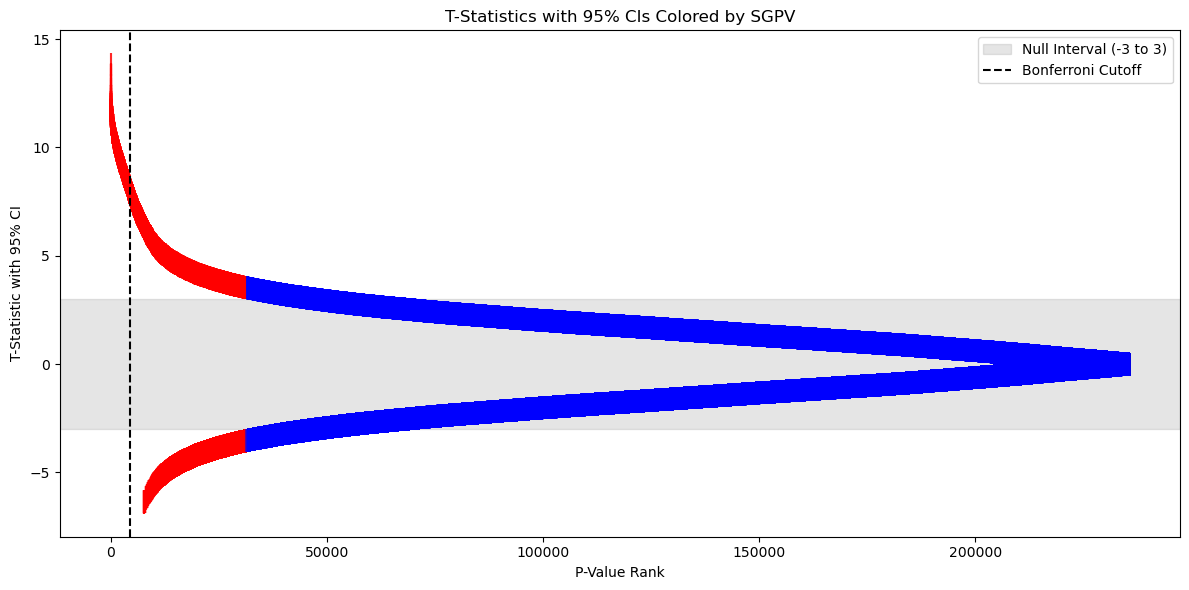

In [24]:
# Define Bonferroni cutoff
bonferroni_x_cutoff = closest_rank

# Only plot top 10000 for visibility
#df_results_top = df_results.nsmallest(10000, 'P-Value Rank')

plt.figure(figsize=(12, 6))

for idx, row in df_results.iterrows():
    color = 'red' if row['SGPV'] == 0 else 'blue'
    # vertical line for CI
    plt.vlines(
        x=row['P-Value Rank'],
        ymin=row['CI Lower'],
        ymax=row['CI Upper'],
        color=color,
        alpha=0.6
    )

# Add horizontal lines for null interval bounds
plt.axhspan(-3, 3, color='grey', alpha=0.2, label='Null Interval (-3 to 3)')

# Add vertical line for Bonferroni cutoff
plt.axvline(
    x=bonferroni_x_cutoff,
    color='black',
    linestyle='--',
    label='Bonferroni Cutoff'
)

plt.xlabel('P-Value Rank')
plt.ylabel('T-Statistic with 95% CI')
plt.title('T-Statistics with 95% CIs Colored by SGPV')
plt.legend()
plt.tight_layout()
plt.show()
